In [1]:
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import pandas as pd
import corner
import emcee

## Haremos un ajuste a los datos del archivo jla_lcparams con usando un likelihood Gaussiano y el siguiente modelo:
## $\boxed{\mu = m_B^* - (M_B-\alpha X_1 + \beta C)}$
### Siendo $\alpha, \beta, M_B$ son parámetros nuisance.
### Empezaremos cargando los datos con sus respectivos errores.

In [107]:
data = np.loadtxt('jla_lcparams.txt',usecols=(1,2,3,4,5,6,7,8,9,10,11,12))
om = 0.3

In [108]:
n = len(data)
mu = np.zeros((2,n))
err = np.zeros((3,n))
mb,X1,C = np.zeros(n),np.zeros(n),np.zeros(n)
for i in range(740):
    mb[i],X1[i],C[i] = data[i,3],data[i,5],data[i,7]
    err[0,i],err[1,i],err[2,i] = data[i,4],data[i,6],data[i,8]
    mu[0,i] = data[i,0]
cosmo = FlatLambdaCDM(H0=70, Om0=om, Tcmb0=2.725).luminosity_distance(mu[0])
mu[1] = 5*np.log10(cosmo.value/10e-6)
erro = err[0]**2 + err[1]**2 + err[2]**2

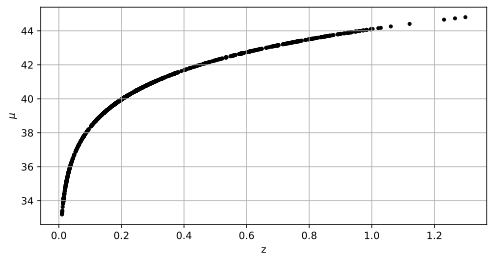

In [104]:
plt.rcParams['figure.figsize'] = (8,4)
#plt.scatter(mu[0], mb + X1 - C, color='black')
plt.scatter(mu[0], mu[1], marker='.',color="black")
#plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.grid()
plt.show()

In [109]:
def prior(u):
    if 0 < u[0] < 2 and 1 < u[1] < 4 and (-22) < u[2] < (-15) and 0 < u[3] < 1.2:
        pri = -np.log((2-(1))*(4-(2))*(-15-(-22))*(1.2-(0)))               #*(1.2-(0))
    else:
        pri = -999999999     #np.NINF
    return pri              

In [114]:
def posterior(w):
    llt = 0
    w[3] = abs(w[3])
    cosmo = FlatLambdaCDM(H0=70, Om0=w[3], Tcmb0=2.725).luminosity_distance(mu[0])
    mu[1] = 5*np.log10(cosmo.value/10e-6)
    fx = mb + X1*w[0] -C*w[1] - w[2]    #w = [alpha,beta,MB]
    for i in range (n):
        llt+= -(1/(2*erro[i]))*(mu[1,i]-fx[i])**2    #erro[i]
    llt += prior(w)
    return llt

In [115]:
pos = [0,2,-19,0.3] + 1e-4 * np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [14:53<00:00,  8.96it/s]


In [116]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(4208, 4)


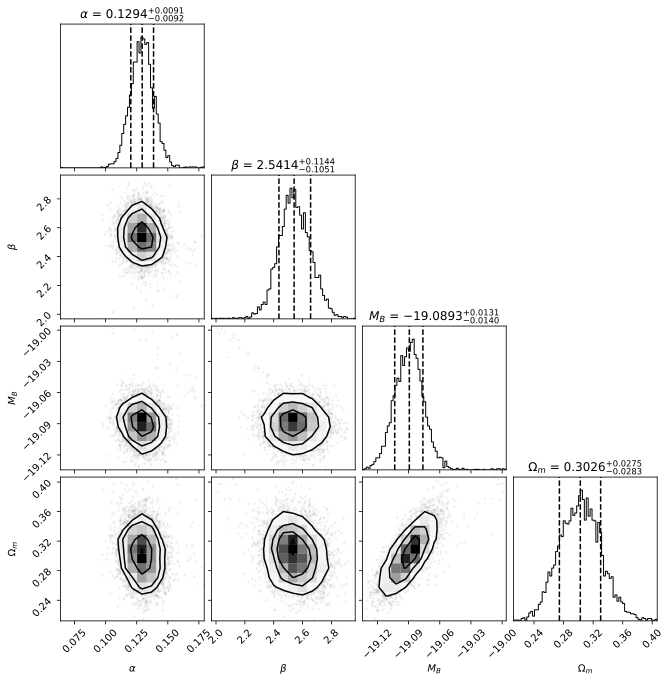

In [117]:
fig = corner.corner(
    flat_samples,
    bins=15,
    hist_bin_factor=5,
    #range=[[0.11,0.14],[2.5,2.8],[-19.1,-19]],
    labels=[r"$\alpha$", r"$\beta$",r"$M_B$",r"$\Omega_m$"],
    quantiles=[0.16, 0.5, 0.84],
    #levels=(1-np.exp(-0.5),),
    title_fmt='.4f',
    show_titles=True, title_kwargs={"fontsize": 12}
);

In [118]:
from IPython.display import display, Math
labels = [r"\alpha", r"\beta","M_B","\Omega_m"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [95]:
res

array([  0.12951509,   2.54791027, -19.09044532,   0.2996532 ])

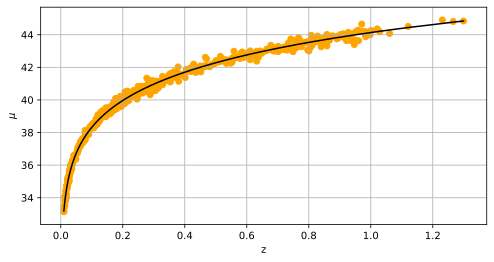

In [121]:
mus = pd.DataFrame({'z':mu[0], 'zz':mu[1]})
mus = mus.sort_values(by=['z'], ignore_index=True)
plt.rcParams['figure.figsize'] = (8,4)
#plt.errorbar(mu[0], mu[1], yerr=np.sqrt(error), xerr = 0, fmt='.', color="black")
plt.plot(mus["z"], mus["zz"], color='black')
plt.scatter(mu[0], mb + X1*res[0] - C*res[1] - res[2], color='orange')
#plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.grid()
plt.show()

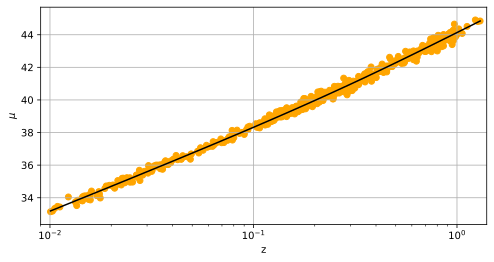

In [133]:
plt.rcParams['figure.figsize'] = (8,4)
plt.plot(mus["z"], mus["zz"], color='black')
plt.scatter(mu[0], mb + X1*res[0] - C*res[1] - res[2], color='orange')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.xlim(0.009,1.4)
plt.grid()
plt.show()